In [ ]:
#getting Dataset directiory from drive
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/Leaf_Disease_Pred"

import os
print("Classes:", os.listdir(data_dir))
for cls in os.listdir(data_dir):
    print(cls, "-", len(os.listdir(os.path.join(data_dir, cls))), "images")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes: ['Bacterial leaf blight', 'Leaf smut', 'Brown spot']
Bacterial leaf blight -> 40 images
Leaf smut -> 39 images
Brown spot -> 40 images


In [ ]:
#importing necessary liabraries

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", tf.__version__)

IMG_SIZE = (224, 224)
BATCH_SIZE = 8
SEED = 42


TensorFlow version: 2.19.0


In [23]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# split val into val + test
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

class_names = train_ds.class_names
print("Detected classes:", class_names)



Found 119 files belonging to 3 classes.
Using 84 files for training.
Found 119 files belonging to 3 classes.
Using 35 files for validation.
Detected classes: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


In [ ]:
#data augumentation

AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

train_ds = train_ds.cache().shuffle(100).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)


In [ ]:
#building models

def build_transfer_model(base_model, num_classes=len(class_names)):
    base_model.trainable = False
    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

# MobileNetV2
mobilenet_base = tf.keras.applications.MobileNetV2(
    include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,)
)
mobilenet_model = build_transfer_model(mobilenet_base)

# EfficientNetB0
efficientnet_base = tf.keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,)
)
efficientnet_model = build_transfer_model(efficientnet_base)


In [ ]:
#dataset training

def compile_and_train(model, train_ds, val_ds, name, epochs=20):
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    ckpt = tf.keras.callbacks.ModelCheckpoint(f"{name}.h5", save_best_only=True, monitor="val_accuracy", mode="max")
    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[ckpt, es])
    return history


In [27]:
print("Training MobileNetV2...")
hist_mobilenet = compile_and_train(mobilenet_model, train_ds, val_ds, "mobilenetv2", epochs=20)

print("\n Training EfficientNetB0...")
hist_effnet = compile_and_train(efficientnet_model, train_ds, val_ds, "efficientnetb0", epochs=20)


Training MobileNetV2...
Epoch 1/20
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3042 - loss: 1.5475

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - accuracy: 0.3150 - loss: 1.5215 - val_accuracy: 0.4737 - val_loss: 1.2957
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3296 - loss: 1.4195 - val_accuracy: 0.4211 - val_loss: 1.2418
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4295 - loss: 1.4827 - val_accuracy: 0.3158 - val_loss: 1.1631
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6025 - loss: 1.0111 - val_accuracy: 0.2632 - val_loss: 1.1181
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4108 - loss: 1.1687 - val_accuracy: 0.3158 - val_loss: 1.0725
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4806 - loss: 1.0534 - val_accuracy: 0.3684 - val_loss: 1.0347
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4968 - loss: 1.0772 - val_accuracy: 0.3684 - val_loss: 0.9942
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5044 - loss: 1.0586 - val_accuracy: 0.3684 - val_loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6978 - loss: 0.7623 - val_accuracy: 0.5263 - val_loss: 0.8318
Epoch 17/20
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7326 - loss: 0.6586

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7355 - loss: 0.6670 - val_accuracy: 0.5789 - val_loss: 0.8166
Epoch 18/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7645 - loss: 0.6518 - val_accuracy: 0.5789 - val_loss: 0.7989
Epoch 19/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7022 - loss: 0.7604 - val_accuracy: 0.5789 - val_loss: 0.7751
Epoch 20/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6767 - loss: 0.7866 - val_accuracy: 0.5789 - val_loss: 0.7584

 Training EfficientNetB0...
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3208 - loss: 1.1794

11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 410ms/step - accuracy: 0.3249 - loss: 1.1760 - val_accuracy: 0.1579 - val_loss: 1.2007
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4154 - loss: 1.1083 - val_accuracy: 0.1579 - val_loss: 1.1808
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3632 - loss: 1.0992 - val_accuracy: 0.1579 - val_loss: 1.1636
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3826 - loss: 1.0857 - val_accuracy: 0.1579 - val_loss: 1.1530
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2675 - loss: 1.1446 - val_accuracy: 0.1579 - val_loss: 1.1510
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4140 - loss: 1.1241 - val_accuracy: 0.1579 - val_loss: 1.1395
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3540 - loss: 1.0795 - val_accuracy: 0.1579 - val_loss: 1.1343
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3830 - loss: 1.0989 - val_accuracy: 0.1579 - val_loss: 

MobileNetV2 - Test Accuracy: 0.6250
                       precision    recall  f1-score   support

Bacterial leaf blight       0.71      1.00      0.83         5
           Brown spot       0.50      0.40      0.44         5
            Leaf smut       0.60      0.50      0.55         6

             accuracy                           0.62        16
            macro avg       0.60      0.63      0.61        16
         weighted avg       0.60      0.62      0.60        16



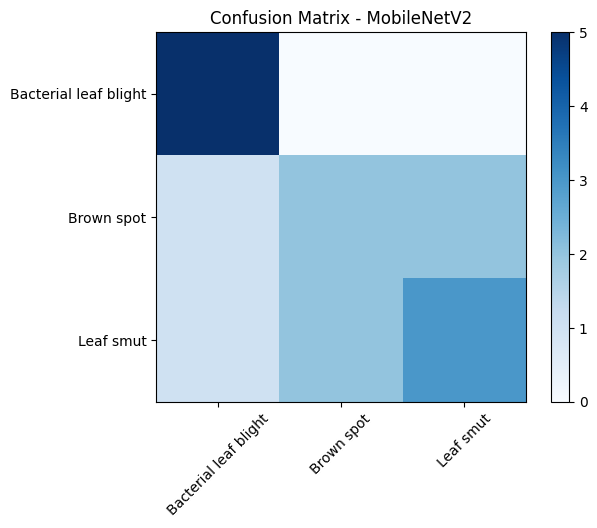

EfficientNetB0 - Test Accuracy: 0.3125
                       precision    recall  f1-score   support

Bacterial leaf blight       0.31      1.00      0.48         5
           Brown spot       0.00      0.00      0.00         5
            Leaf smut       0.00      0.00      0.00         6

             accuracy                           0.31        16
            macro avg       0.10      0.33      0.16        16
         weighted avg       0.10      0.31      0.15        16



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


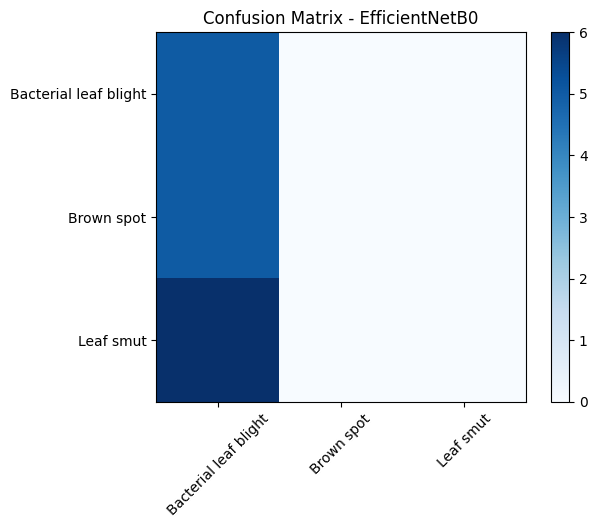

In [ ]:
#model evaluation

def evaluate_model(model, test_ds, name):
    loss, acc = model.evaluate(test_ds, verbose=0)
    print(f"{name} - Test Accuracy: {acc:.4f}")

    y_true, y_pred = [], []
    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.colorbar()
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks(range(len(class_names)), class_names)
    plt.show()

evaluate_model(mobilenet_model, test_ds, "MobileNetV2")
evaluate_model(efficientnet_model, test_ds, "EfficientNetB0")


In [ ]:
mobilenet_model.save("/content/best_riceleaf_model.h5")
print("Best model saved at /content/best_riceleaf_model.h5 (download from left sidebar in Colab)")

✅ Best model saved at /content/best_riceleaf_model.h5 (download from left sidebar in Colab)
